**Objetivo**: Carregar e testar a rede neural treinada


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

import os
PATH = '/content/gdrive/Shareddrives/IA901 - Projeto Final/'
data_dir = PATH+'Datasets/Processed'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Criando pasta para salvar resultados preliminares/finais

PATHFinal = PATH+'Notebooks/FinalResults/'

if not os.path.exists(PATHFinal):
  os.mkdir(PATHFinal)

In [ ]:
# ______________________________________________________________________________
# Pegando resultados do experimento escolhido

print('Lista de experimentos disponíveis: ', os.listdir(PATH+"Notebooks/InterimResults/"))
print('Diga o numero do experimento que você gostaria de carregar (Experiment_Name)')
ExperimentName = str (input()) # por ex. 'DL_Baseline'

path_interim = PATH+"Notebooks/InterimResults/{}".format(ExperimentName)

print('Lista de subexperimentos disponíveis: ', os.listdir(path_interim)[1:])
print('Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)')
Experiment_Number = str (input())
subpath = path_interim+'/{}'.format(Experiment_Number)

Lista de experimentos disponíveis:  ['DL_Baseline', 'Experiment_I']
Diga o numero do experimento que você gostaria de carregar (Experiment_Name)
Experiment_I
Lista de subexperimentos disponíveis:  ['3']
Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)
3


In [ ]:
PATHFinalExperiment = PATHFinal+'{}/'.format(ExperimentName)

if not os.path.exists(PATHFinalExperiment):
  os.mkdir(PATHFinalExperiment)

# Configurações gerais e funções úteis para as análises

In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import re
plt.ion()   # interactive mode

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd

def AnalysisPlots(classe_teste, PrevisoesProb):

  # Construindo a ROC Curve
  # A função abaixo retorna arrays de True Positive Rate (TPR), False Positive Rate (FPR) e os valores de threshold
  FPR, TPR, thresholds = metrics.roc_curve(classe_teste, PrevisoesProb, drop_intermediate=False) 

  # Calculo da AUC
  auc = metrics.roc_auc_score(classe_teste, PrevisoesProb) 

  # Plotando ROC Curve com matplotlib:
  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(FPR, TPR, label="AUC ="+np.format_float_positional(auc, precision=3))
  ax.plot([0,1], [0,1], linestyle='--', label='Random Selection, AUC = 0.5')
  ax.set_xlabel('False Positive Rate', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('ROC Curve', fontsize=15)
  ax.grid()
  ax.legend(loc='lower right')
  plt.savefig(PATHFinalExperiment+'/ROC.png')
  plt.show()

  plt.clf() # limpando janela de plot

  # Plot TPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, TPR)
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('TPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  plt.savefig(PATHFinalExperiment+'/TPRxThreshold.png')
  plt.show()

  plt.clf() # limpando janela de plot

  # Plot FPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, FPR)
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('False Positive Rate', fontsize=15)
  ax.set_title('FPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  plt.savefig(PATHFinalExperiment+'/FPRxThreshold.png')
  plt.show()


  plt.clf() # limpando janela de plot

  # Dataframe com indice de Youden:
  DataFrameYouden = pd.DataFrame(data={'Threshold':thresholds,'Youden':TPR - FPR})

  # Dataframe com indice maximo de Youden:
  DataFrameYoudenMax = DataFrameYouden.sort_values(by='Youden', ascending = False) # Ordenando em ordem crescente

  # Print do valor de threshold que maximiza o índice de Youden:
  print('\n Melhor Decision Threshold: ', DataFrameYoudenMax.Threshold.values[0]) # printando valor de threshold que maximiza o Youden
  print('\n Melhor Índice de Youden: ', DataFrameYoudenMax.Youden.values[0]) # printando valor maximo do Youden

  return DataFrameYoudenMax.Threshold.values[0]


In [ ]:
def Test_model(model, threshold=0.5):
    model.eval()

    Probabilities = []
    ClassLabels = []
    names = []
    predictions = []

    incorrect_images = []
    incorrect_predictions = []
    correct_labels = []

    with torch.no_grad():

            # Iterate over data.
            for k, (inputs, labels, paths) in enumerate(dataloaders['test']):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                predicted = (outputs > threshold).float()
                _, predicted = torch.max(predicted, 1)

                predictions.extend(predicted.cpu().numpy())
            
                for i in range(len(labels)):
                    if predicted[i] != labels[i]:
                        incorrect_images.append(inputs[i].cpu().numpy())
                        incorrect_predictions.append(predicted[i])
                        correct_labels.append(labels[i])

                Probabilities.append(outputs.cpu().detach().numpy()[:,1])
                ClassLabels.append(labels.cpu().detach().numpy())

                for j in range(inputs.size()[0]):
                  temp = re.findall(r'\d+', paths[j].split('/')[9])
                  res = list(map(int, temp))
                  #print('filename: {}, number: {}'.format(paths[j].split('/')[9], res[0]))
                  names.append(res[0])

    # Convert the incorrect images to a numpy array
    incorrect_images = np.array(incorrect_images)

    return np.concatenate(Probabilities).ravel(), np.concatenate(ClassLabels).ravel(), names, incorrect_images, incorrect_predictions, correct_labels

In [ ]:
def VisualizeErrors(incorrect_images, incorrect_predictions, correct_labels, num_images=None):
    
  if num_images==None:
    num_images = 3
  # Plot the incorrect images
  fig, axs = plt.subplots(1, num_images, figsize=(15, 8))
  axs = axs.flatten()
  for i in range(num_images):
      axs[i].imshow(np.transpose(incorrect_images[i], (1, 2, 0)))
      axs[i].set_title('Predicted: {}, Actual: {}'.format(incorrect_predictions[i], correct_labels[i]))
      axs[i].axis('off')
  plt.savefig(PATHFinalExperiment+"/DL_WrongPredictions.png")
  plt.show()

## Testando o modelo

## Carregar dados


In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
# Data augmentation and normalization for training

size, padding = 224, 30 # tamanho de entrada da EfficientNet B1

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Código que carrega melhor rede neural

# Define your model
model = models.efficientnet_b0(weights=True)
model.classifier[1] = nn.Linear(in_features= model.classifier[1].in_features, out_features=2)

# Add a softmax activation to the output layer
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.to(device)

# Load your saved model
ModelPATH = subpath+'/Trained_DLModel.pt'
model.load_state_dict(torch.load(ModelPATH, map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# Predicoes:
Predictions, classes, filenames, incorrect_images, incorrect_predictions, correct_labels = Test_model(model)

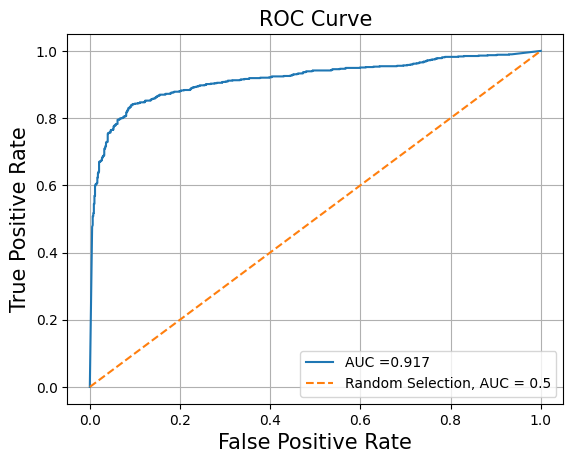

<Figure size 640x480 with 0 Axes>

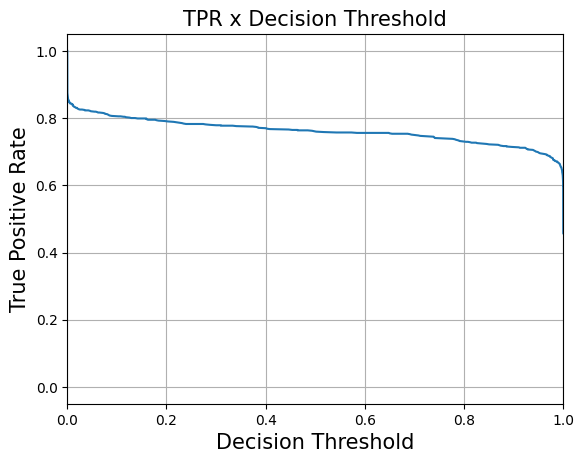

<Figure size 640x480 with 0 Axes>

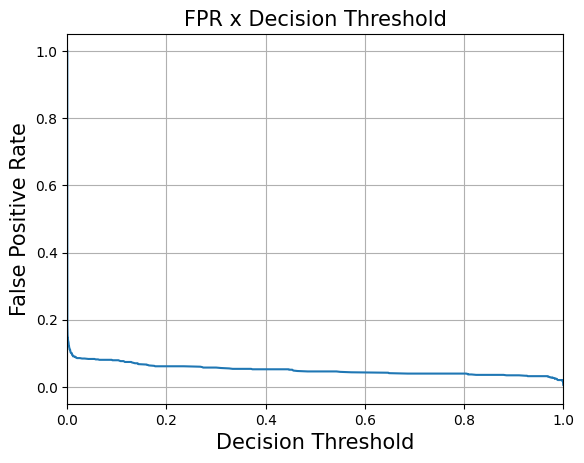


 Melhor Decision Threshold:  0.01183326

 Melhor Índice de Youden:  0.7472704286863578


<Figure size 640x480 with 0 Axes>

In [ ]:
BestThreshold = AnalysisPlots(classes, Predictions)

In [ ]:
TestInfos = pd.read_csv("/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Processed/TestLabels.csv")
result = TestInfos[TestInfos['Unnamed: 0'].isin(filenames)]
result.sort_values('Unnamed: 0', inplace=True)
result

<ipython-input-34-df11d968267a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.sort_values('Unnamed: 0', inplace=True)


,Unnamed: 0,Types,Class
513,1,Breast,1.0
340,4,Breast,1.0
205,11,Breast,1.0
413,16,Breast,1.0
375,19,Breast,1.0
...,...,...,...
855,7865,Colon,0.0
747,7876,Colon,0.0
956,7879,Colon,1.0
795,7887,Colon,0.0


In [ ]:
# Incluindo informacao do tecido sobre as predicoes
TestInfos = pd.read_csv("/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Processed/TestLabels.csv")
TestInfos = TestInfos[TestInfos['Unnamed: 0'].isin(filenames)]
TestInfos.sort_values('Unnamed: 0', inplace=True)

# Saving Final predictions
DL_Results = pd.DataFrame({'ImageID':filenames, 'Pred':Predictions, 'Class':classes})
DL_Results.sort_values('ImageID', inplace=True)
DL_Results['Types'] = TestInfos['Types'].values

DL_Results.to_csv(PATHFinalExperiment+"/DL_Prediction.csv", index=False, encoding='utf-8')
DL_Results

,ImageID,Pred,Class,Types
904,1,4.936130e-01,1,Breast
383,4,2.276664e-04,1,Breast
103,11,9.940318e-01,1,Breast
1026,16,7.813437e-01,1,Breast
1148,19,1.587927e-03,1,Breast
...,...,...,...,...
1512,7865,4.564904e-13,0,Colon
1569,7876,3.265832e-13,0,Colon
219,7879,9.999927e-01,1,Colon
66,7887,1.130203e-09,0,Colon


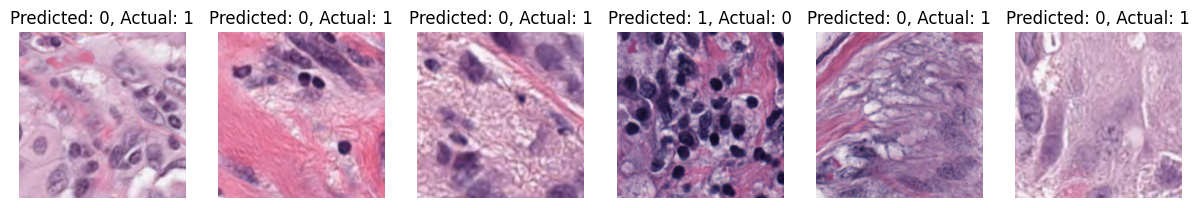

In [ ]:
# Visualizando erros cometidos pelo modelo
VisualizeErrors(incorrect_images, incorrect_predictions, correct_labels, num_images=6)

# Análise de qual tecido foi mais difícil de acertar

In [ ]:
from collections import Counter

Classification = DL_Results.copy()

# Classificação baseada no melhor valor de decision threshold obtido via Youden Index!
Classification.loc[Classification["Pred"]>=BestThreshold, "Pred"] = 1
Classification.loc[Classification["Pred"]<BestThreshold, "Pred"] = 0

# Selecionando apenas as linhas com predicoes incorretas
Classification = Classification.loc[Classification["Pred"]!=Classification["Class"]]

print('Quantidade de imagens classificadas incorretamente: ', len(Classification))

Quantidade de imagens classificadas incorretamente:  199


In [ ]:
# Contando os tipos de cada tecido
TypesTotal = Counter(DL_Results['Types'])
TypesTotal

Counter({'Breast': 470,
         'Colon': 288,
         'Lung': 36,
         'Kidney': 26,
         'Prostate': 35,
         'Bladder': 29,
         'Stomach': 29,
         'Ovarian': 29,
         'Esophagus': 84,
         'Pancreatic': 39,
         'Uterus': 37,
         'Thyroid': 45,
         'Skin': 37,
         'Cervix': 58,
         'Adrenal_gland': 87,
         'Bile-duct': 84,
         'Testis': 39,
         'HeadNeck': 76,
         'Liver': 44})

In [ ]:
# Contando os erros de cada tipo de tecido
Erros = Counter(Classification['Types'])
Erros

Counter({'Breast': 118,
         'Colon': 17,
         'Esophagus': 5,
         'Lung': 1,
         'Uterus': 3,
         'Thyroid': 6,
         'Adrenal_gland': 3,
         'Cervix': 2,
         'Bile-duct': 17,
         'HeadNeck': 8,
         'Liver': 5,
         'Stomach': 4,
         'Skin': 2,
         'Testis': 2,
         'Bladder': 2,
         'Prostate': 2,
         'Kidney': 2})

In [ ]:
# Printa a porcentagem de erros cometidos para cada tecido

[(i, round(Erros[i] / TypesTotal[i] * 100.0, 2)) for i in Erros]

[('Breast', 25.11),
 ('Colon', 5.9),
 ('Esophagus', 5.95),
 ('Lung', 2.78),
 ('Uterus', 8.11),
 ('Thyroid', 13.33),
 ('Adrenal_gland', 3.45),
 ('Cervix', 3.45),
 ('Bile-duct', 20.24),
 ('HeadNeck', 10.53),
 ('Liver', 11.36),
 ('Stomach', 13.79),
 ('Skin', 5.41),
 ('Testis', 5.13),
 ('Bladder', 6.9),
 ('Prostate', 5.71),
 ('Kidney', 7.69)]